In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from catboost import CatBoostRegressor
import optuna 
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import warnings
from scipy.signal import savgol_filter

%matplotlib inline

In [2]:
np.random.seed(1)
    
   
torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [3]:
FILE_WAY = '/kaggle/input/nasa-battery-dataset/cleaned_dataset' 
metadata = pd.read_csv(f'{FILE_WAY}/metadata.csv')
metadata.head()  # Capacity ~ SOH

,type,start_time,ambient_temperature,battery_id,test_id,uid,filename,Capacity,Re,Rct
0,discharge,[2010. 7. 21. 15. 0. ...,4,B0047,0,1,00001.csv,1.6743047446975208,NaN,NaN
1,impedance,[2010. 7. 21. 16. 53. ...,24,B0047,1,2,00002.csv,NaN,0.05605783343888099,0.20097016584458333
2,charge,[2010. 7. 21. 17. 25. ...,4,B0047,2,3,00003.csv,NaN,NaN,NaN
3,impedance,[2010 7 21 20 31 5],24,B0047,3,4,00004.csv,NaN,0.05319185850921101,0.16473399914864734
4,discharge,[2.0100e+03 7.0000e+00 2.1000e+01 2.1000e+01 2...,4,B0047,4,5,00005.csv,1.5243662105099023,NaN,NaN


In [4]:
class Battery:
    """NASA battery data loader and processor."""
    
    def __init__(self, bat_id, to_sort = False, tensor = False, 
                 crop = None, drop_time = False):
        """
        Args:
            bat_id: Battery ID from metadata
            to_sort: Sort capacity values if True
            tensor: Convert to PyTorch tensors if True  
            crop: Crop cycles to this length
            drop_time: Remove Time column if True
        """
        self.tensor = tensor
        self.bat_id = bat_id
        mask = (metadata['battery_id'] == self.bat_id) & (metadata['type'] == 'discharge')
        self.capacity =  metadata.loc[mask].copy()
        self.capacity.loc[:, 'Capacity'] = pd.to_numeric(self.capacity['Capacity']) / 2.0 # init capacity
        
        if to_sort:
            self.capacity = self.capacity.sort_values('Capacity')
            
        self.y = np.array(self.capacity['Capacity'], dtype=float)
        
        if tensor:
            self.y = torch.tensor(self.y, dtype=torch.float32)

        self._clean_data()
        self._get_data(crop=crop, drop_time=drop_time)
        self._ica_features()

    def _clean_data(self):
        """Очистка данных - исправленная версия"""
        self.cleaned_tables = []
        
        for file in self.capacity['filename']:
            table = pd.read_csv(f'{FILE_WAY}/data/{file}')
            table_array = table.values  
            
        
            min_v_ind = table_array[:, 0].argmin()
            min_time = table_array[min_v_ind, -1]   
            
        
            mask = table_array[:, -1] < min_time 
            self.cleaned_tables.append(table_array[mask])
        
        

    def _get_data(self, crop, drop_time=False): 
        self.table = []
        index = []
        for ind, table in enumerate(self.cleaned_tables):   
            if drop_time:
                table = table.drop(columns=['Time'])
                
            if table.shape[0] >= crop:
                self.table.append(np.array(table)[table.shape[0] - crop:])
                index.append(ind)
        self.index = index

        self.y = self.y[index]

        self.table = np.array(self.table)
        
        
    def _ica_features(self):
        '''
        obtain ICA_data from cleaned tablestable
        '''
        max_volt = 4.2
        min_voltages = {5: 2.7, 6: 2.7, 7: 2.2, 18: 2.5} # from additional data
        min_volt = min_voltages[int(self.bat_id[2:])]
        features = []
        dqdv = []
        voltage_all = []
        
        
        for tab, ind in zip(self.cleaned_tables, self.index):
            if ind not in self.index:
                continue
            voltage = tab[:, 0]  
            current = tab[:, 1]  
            time = tab[:, -1]  
    
            # filter by cut_off voltage
            mask = (voltage >= min_volt) & (voltage <= max_volt)
            voltage = voltage[mask]
            current = current[mask]
            time = time[mask]
            
            dt = np.diff(time, prepend=time[0]) / 3600  
    
            Q = np.cumsum(np.abs(current) * dt)
    
            dQ = np.gradient(Q)
            dV = np.gradient(voltage)
            dQ_dV = dQ / dV
    
            dQ_dV_smooth = savgol_filter(dQ_dV, window_length=30 , polyorder=2)
    
            peak_height = np.min(dQ_dV_smooth)
            peak_idx = np.argmin(dQ_dV_smooth)
            peak_voltage = voltage[peak_idx]  
            area_under_curve = np.trapz(dQ_dV_smooth, voltage)
    
            features.append([peak_height, peak_voltage, area_under_curve]) 

            new_len = min(len(dQ_dV_smooth), len(tab))
            dqdv.append(dQ_dV_smooth[:new_len])
            voltage_all.append(voltage[:new_len])
  
        self.ica = np.array(features)
        self.ica = self.ica
        self.dqdv = dqdv
        self.volt = voltage_all

    def build_ica(self, diap=(float('-inf'), float('inf'))):
        fig, ax = plt.subplots()
        for v, ic in zip(self.volt, self.dqdv):
            mask = (v > diap[0]) & (v < diap[1])
            ax.plot(v[mask], 1000 * ic[mask])
            dqdv_max = ic.min()
            v_max = v[ic.argmin()]
            ax.plot(v_max, 1000 * dqdv_max, marker='*', color='red')
        ax.set_xlabel(r'Voltage (V)', fontsize=15)
        ax.set_ylabel(r'dQ/dV (mAh/V)', fontsize=15)
        ax.set_title(f'All ica for {self}')
            
    def __str__(self):
        return f"Battery_{int(self.bat_id[-2:])}"

        

def results(y_test: np.ndarray, y_pred: np.ndarray, ax: plt.Axes = None, 
           label: str = '') -> dict:
    """
    Plot and calculate metrics for SOH predictions.
    
    Returns:
        dict with r2, rmse, mae metrics
    """
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    print(f'R2 score = {r2:.3f}')
    print(f'rmse = {100 * rmse:.3f}%')
    print(f'mae = {mae:.3f}')
    if ax is None:
        fig, ax = plt.subplots(figsize=(15,15))
    cycles = np.arange(1, len(y_test) + 1)
    ax.plot(cycles, y_test, color='red', label='Test SOH')
    ax.plot(cycles, y_pred, color='green', label='Predicted SOH')
    ax.set_xlabel('Cycle', fontsize=20)
    ax.set_ylabel('SOH', fontsize=20)
    ax.set_title(label, fontsize=20)
    plt.grid()
    ax.legend(fontsize=15)
    return {'r2': r2, 'rmse': rmse, 'mae': mae}




In [5]:
bat7 = Battery('B0007', crop=10)
min_crop = min([i.shape[0] for i in bat7.cleaned_tables])
bat7 = Battery('B0007', crop=min_crop)
X_test_np = bat7.table
X_test_np = X_test_np.reshape(X_test_np.shape[0], -1)
y_test_np = bat7.y

bat5 = Battery('B0005', crop=min_crop)
bat6 = Battery('B0006', crop=min_crop)

X_train_np = np.concatenate([bat5.table, bat6.table], 0)
X_train_np = X_train_np.reshape(X_train_np.shape[0], -1)
y_train_np = np.concatenate([bat5.y, bat6.y], -1)

bat18 = Battery('B0018', crop=min_crop)

X_val_np = bat18.table
X_val_np = X_val_np.reshape(X_val_np.shape[0], -1)
y_val_np = bat18.y

X_train_np.shape, X_val_np.shape, X_test_np.shape
# y_train_np.shape

((308, 1068), (132, 1068), (168, 1068))

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [7]:
pd.read_csv('/kaggle/input/nasa-battery-dataset/cleaned_dataset/data/00001.csv')

,Voltage_measured,Current_measured,Temperature_measured,Current_load,Voltage_load,Time
0,4.246711,0.000252,6.212696,0.0002,0.000,0.000
1,4.246764,-0.001411,6.234019,0.0002,4.262,9.360
2,4.039277,-0.995093,6.250255,1.0000,3.465,23.281
3,4.019506,-0.996731,6.302176,1.0000,3.451,36.406
4,4.004763,-0.992845,6.361645,1.0000,3.438,49.625
...,...,...,...,...,...,...
485,3.303251,-0.001760,9.662331,0.0004,0.000,6382.063
486,3.310303,-0.000756,9.390489,0.0002,0.000,6395.547
487,3.317351,-0.003318,9.137008,0.0002,0.000,6409.063
488,3.323387,-0.002291,8.972806,0.0002,0.000,6422.625


In [ ]:
from sklearn.models import LinearRegression

lr = LinearRegression()
lr.fit(ica_train, y_train_np)
pred18 = lr.predict(ica_val)
pred7 = lr.predict(ica_test)
results(y_val_np, pred18)
results(y_test_np, pred7)

In [11]:
# try catboost with optuna.
def objective_catboost(trial, X_train, y_train, X_val, y_val):
    params = {
        'iterations': trial.suggest_int('iterations', 500, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10, log=True),
        'random_strength': trial.suggest_float('random_strength', 0.1, 10, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 1, 15),
        'verbose': False, 
        'random_seed': 1488,
        'loss_function': 'RMSE',  
        'task_type': 'GPU',  
        # uncomment if cuda is available 
    }
   
    
    model = CatBoostRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        early_stopping_rounds=50,
        verbose=False
    )
    
    y_val_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_val_pred)

    return 100 * np.sqrt(mse)

In [13]:
# GBT on ica data
ica_train = np.concatenate([bat5.ica, bat6.ica])
ica_val = bat18.ica
ica_test = bat7.ica
study_catboost = optuna.create_study(
    direction='minimize'
)

study_catboost.optimize(lambda trial: objective_catboost(trial, ica_train, 
                                                         y_train_np, ica_val, y_val_np), 
                        n_trials=10, show_progress_bar=True)



[I 2025-10-09 11:37:59,432] A new study created in memory with name: no-name-40012647-d194-48bc-8782-da81034310bf


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-09 11:40:22,401] Trial 0 finished with value: 2.800748066273522 and parameters: {'iterations': 1453, 'learning_rate': 0.010958926316737486, 'depth': 8, 'l2_leaf_reg': 3.421106592018825, 'random_strength': 2.0730472196997387, 'bagging_temperature': 0.7325876394295683, 'leaf_estimation_iterations': 15}. Best is trial 0 with value: 2.800748066273522.
[I 2025-10-09 11:40:31,630] Trial 1 finished with value: 2.4608567962245083 and parameters: {'iterations': 792, 'learning_rate': 0.007652257227657857, 'depth': 5, 'l2_leaf_reg': 2.4785882453084667, 'random_strength': 0.5724104572138, 'bagging_temperature': 0.8803731620009173, 'leaf_estimation_iterations': 3}. Best is trial 1 with value: 2.4608567962245083.
[I 2025-10-09 11:41:40,952] Trial 2 finished with value: 2.600958004653504 and parameters: {'iterations': 1882, 'learning_rate': 0.005349395050762167, 'depth': 6, 'l2_leaf_reg': 1.540848557722499, 'random_strength': 3.804161993109292, 'bagging_temperature': 0.34155951967316034, '

In [14]:
study_catboost.best_params

{'iterations': 1208,
 'learning_rate': 0.026085091544031287,
 'depth': 5,
 'l2_leaf_reg': 1.0390664347488863,
 'random_strength': 0.11011285654625992,
 'bagging_temperature': 0.18332478085659232,
 'leaf_estimation_iterations': 15}

In [15]:
best_cat_model = CatBoostRegressor(**study_catboost.best_params)
best_cat_model.fit(
    ica_train, y_train_np,
    eval_set=(ica_val, y_val_np),
    early_stopping_rounds=50,
    verbose=False
)

R2 score = 0.731
rmse = 4.160%
mae = 0.035


{'r2': 0.7312462349540723,
 'rmse': 0.04159515814774701,
 'mae': 0.035199913952754}

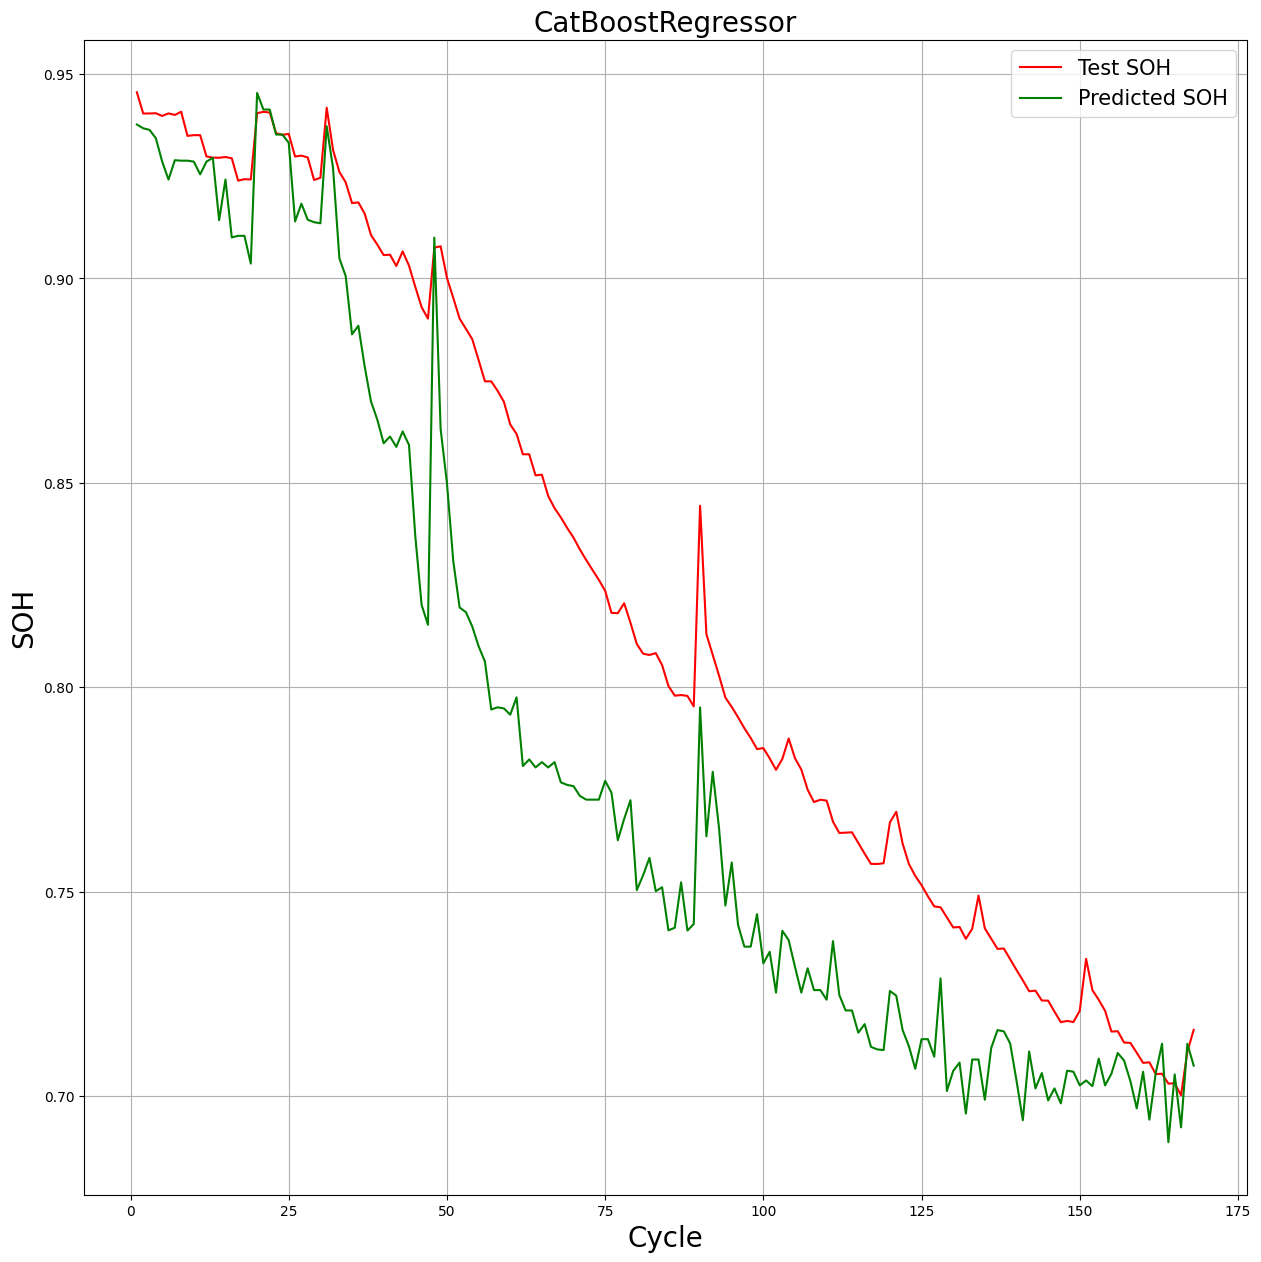

In [16]:
# GBT results on ica data
y_cat_pred = best_cat_model.predict(ica_test)
results(y_test_np, y_cat_pred, label='CatBoostRegressor')

In [26]:
# GBT on ica + flattened data
X_train_ica_np = np.concatenate([X_train_np, ica_train], axis=1)
X_val_ica_np = np.concatenate([X_val_np, ica_val], axis=1)
X_test_ica_np = np.concatenate([X_test_np, ica_test], axis=1)


study_catboost_ica = optuna.create_study(
    direction='minimize'
)

study_catboost_ica.optimize(lambda trial: objective_catboost(trial, X_train_ica_np, 
                                                         y_train_np, X_val_ica_np, y_val_np), 
                        n_trials=10, show_progress_bar=True)


[I 2025-10-09 11:58:59,807] A new study created in memory with name: no-name-d0150773-f1b6-4bb3-9d44-5c77c03742ca


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-09 11:59:13,235] Trial 0 finished with value: 1.402268105561396 and parameters: {'iterations': 704, 'learning_rate': 0.02095339152439337, 'depth': 6, 'l2_leaf_reg': 2.8541798995942225, 'random_strength': 0.4869598050919422, 'bagging_temperature': 0.3979168937730394, 'leaf_estimation_iterations': 4}. Best is trial 0 with value: 1.402268105561396.
[I 2025-10-09 11:59:41,287] Trial 1 finished with value: 3.8459567721836723 and parameters: {'iterations': 1076, 'learning_rate': 0.008499525217714169, 'depth': 5, 'l2_leaf_reg': 8.241853563770553, 'random_strength': 8.511627652015525, 'bagging_temperature': 0.031098832886142458, 'leaf_estimation_iterations': 15}. Best is trial 0 with value: 1.402268105561396.
[I 2025-10-09 12:00:21,975] Trial 2 finished with value: 2.411458880587907 and parameters: {'iterations': 1546, 'learning_rate': 0.02180863651703949, 'depth': 7, 'l2_leaf_reg': 5.076982694229156, 'random_strength': 1.6327485508824255, 'bagging_temperature': 0.4762342447780401, 

KeyboardInterrupt: 

In [27]:
 # Trial 2 finished with value: 0.751996217413767 and parameters: 
params_comb = {'iterations': 1800, 'learning_rate': 0.06873423841222116, 'depth': 6, 'l2_leaf_reg': 3.5762424628942484, 'random_strength': 0.10994507937161954, 'bagging_temperature': 0.07226081978967236, 'leaf_estimation_iterations': 4}

{'iterations': 1800, 'learning_rate': 0.06873423841222116, 'depth': 6, 'l2_leaf_reg': 3.5762424628942484, 'random_strength': 0.10994507937161954, 'bagging_temperature': 0.07226081978967236, 'leaf_estimation_iterations': 4}
R2 score = 0.960
rmse = 1.595%
mae = 0.015


{'r2': 0.9604976199905595,
 'rmse': 0.01594693164153791,
 'mae': 0.014817467692835692}

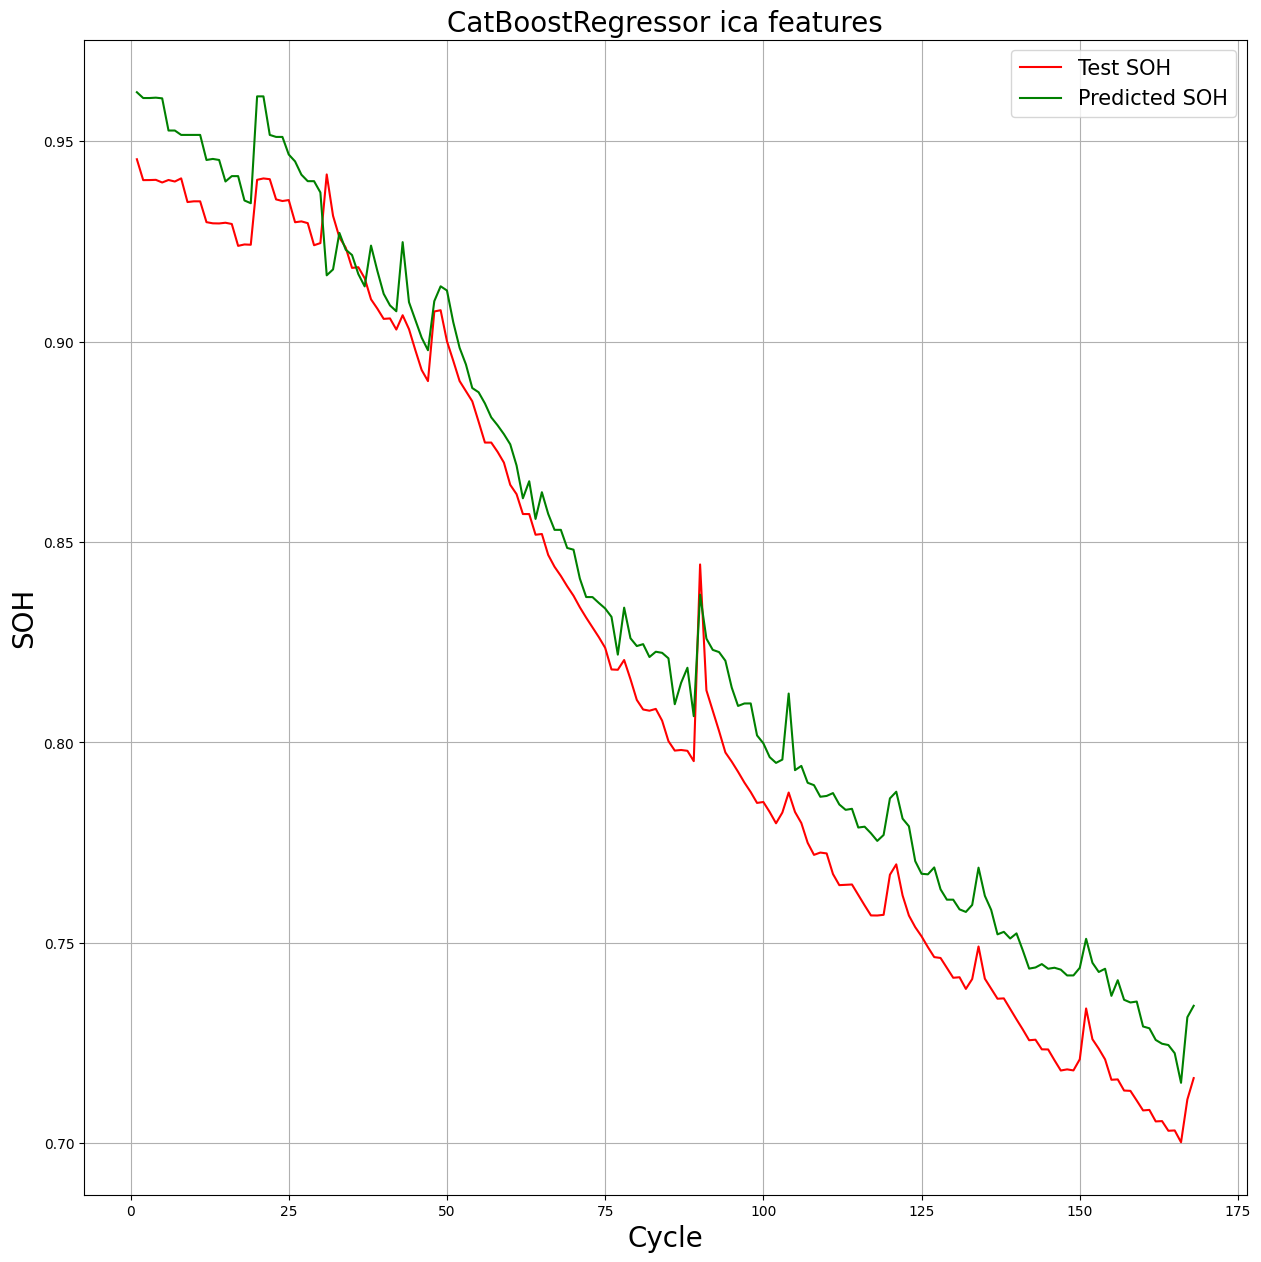

In [30]:
print(params_comb)
best_cat_model_ica = CatBoostRegressor(**params_comb)
best_cat_model_ica.fit(
    X_train_ica_np, y_train_np,
    eval_set=(X_val_ica_np, y_val_np),
    early_stopping_rounds=50,
    verbose=False
)

y_cat_pred = best_cat_model_ica.predict(X_test_ica_np)
results(y_test_np, y_cat_pred, label='CatBoostRegressor ica features')

In [31]:
# GBT usage on flattened data
study_catboost_ica = optuna.create_study(
    direction='minimize'
)

study_catboost_ica.optimize(lambda trial: objective_catboost(trial, X_train_np, 
                                                         y_train_np, X_val_np, y_val_np), 
                        n_trials=10, show_progress_bar=True)


[I 2025-10-09 12:07:00,397] A new study created in memory with name: no-name-a907fcaa-73d0-4934-be30-e1a1f9217e31


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-09 12:07:01,942] Trial 0 finished with value: 3.742550809102273 and parameters: {'iterations': 661, 'learning_rate': 0.07571938175316938, 'depth': 4, 'l2_leaf_reg': 1.6382343803357111, 'random_strength': 1.6543718517804331, 'bagging_temperature': 0.6777012563011929, 'leaf_estimation_iterations': 2}. Best is trial 0 with value: 3.742550809102273.
[I 2025-10-09 12:07:04,471] Trial 1 finished with value: 1.995654758074736 and parameters: {'iterations': 1958, 'learning_rate': 0.05195584547496883, 'depth': 4, 'l2_leaf_reg': 2.0273858299846843, 'random_strength': 0.398340565969342, 'bagging_temperature': 0.7390297183956415, 'leaf_estimation_iterations': 4}. Best is trial 1 with value: 1.995654758074736.
[I 2025-10-09 12:07:32,211] Trial 2 finished with value: 2.067829444588586 and parameters: {'iterations': 883, 'learning_rate': 0.021287957052890934, 'depth': 6, 'l2_leaf_reg': 9.02978209256474, 'random_strength': 0.8760223897486851, 'bagging_temperature': 0.5066631616515045, 'leaf

KeyboardInterrupt: 

{'iterations': 1958, 'learning_rate': 0.05195584547496883, 'depth': 4, 'l2_leaf_reg': 2.0273858299846843, 'random_strength': 0.398340565969342, 'bagging_temperature': 0.7390297183956415, 'leaf_estimation_iterations': 4}
R2 score = 0.938
rmse = 1.993%
mae = 0.018


{'r2': 0.9382861739784335,
 'rmse': 0.019932268888574148,
 'mae': 0.017924794235003576}

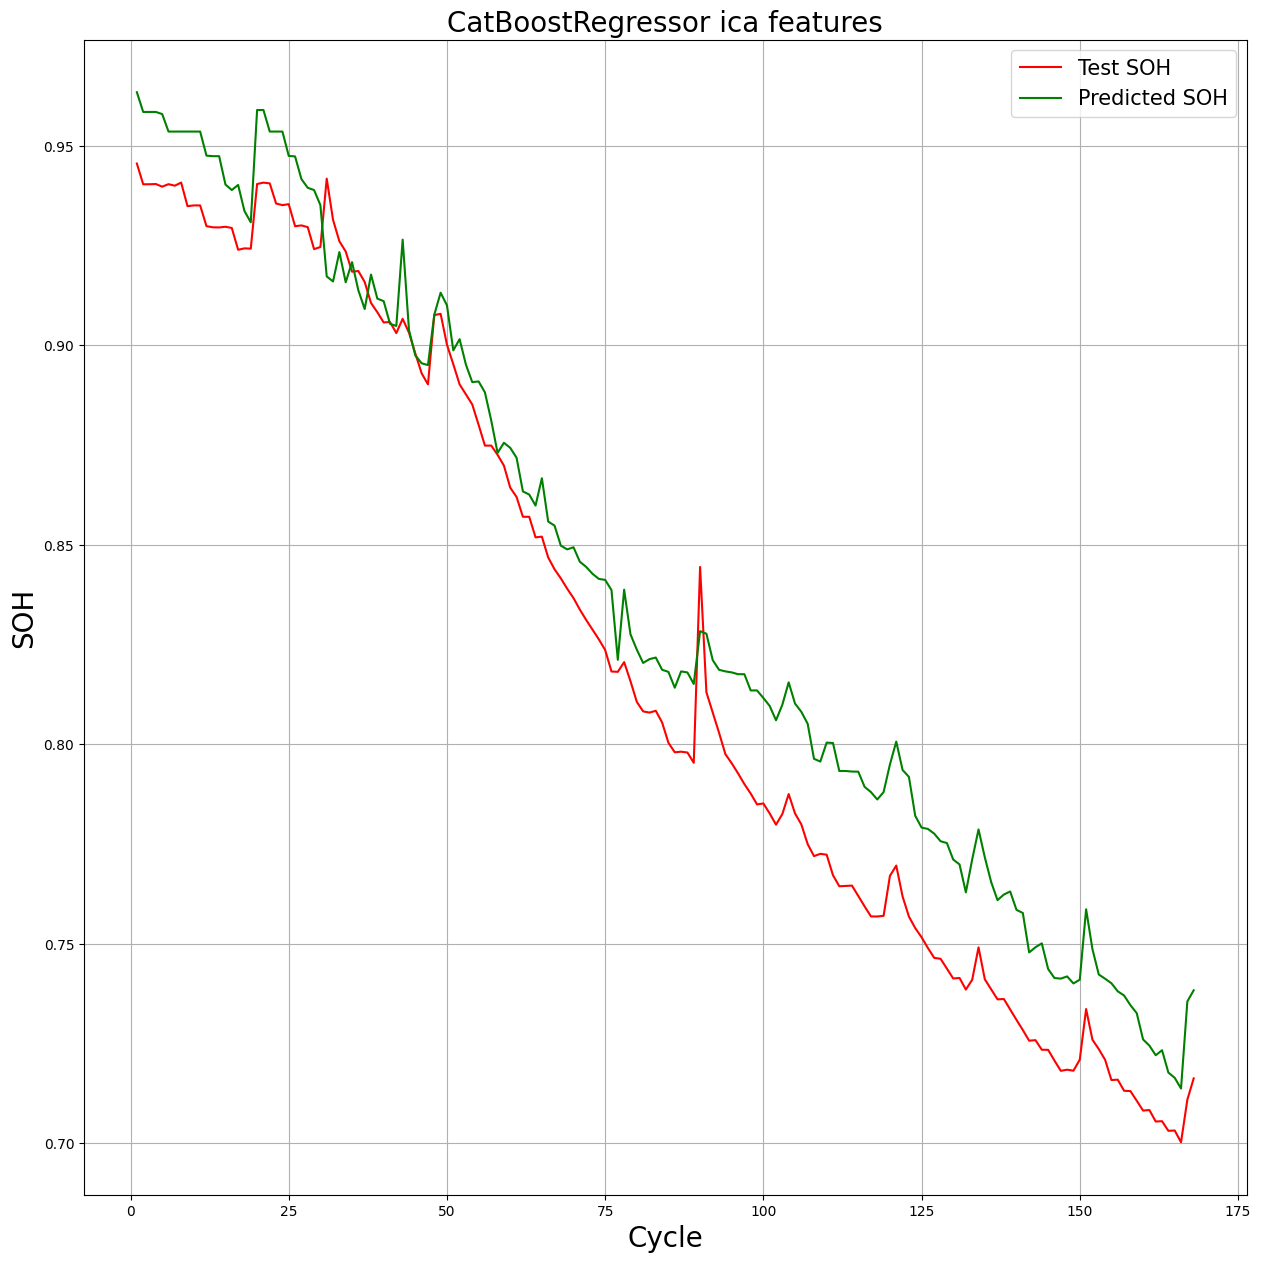

In [32]:
print(study_catboost_ica.best_params)
best_cat_model_ica = CatBoostRegressor(**study_catboost_ica.best_params)
best_cat_model_ica.fit(
    X_train_np, y_train_np,
    eval_set=(X_val_np, y_val_np),
    early_stopping_rounds=50,
    verbose=False
)

y_cat_pred = best_cat_model_ica.predict(X_test_np)
results(y_test_np, y_cat_pred, label='CatBoostRegressor ica features')